In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf
from keras.layers import Dense, LSTM
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('working_dataset.pkl')

In [3]:
data = df.values
train_X = MinMaxScaler().fit_transform(data[:, 2:])
train_X = np.array([train_X[i-16:i, :] for i in range(16, len(data))], dtype=np.float32)
train_X = tf.convert_to_tensor(train_X)
train_y = tf.convert_to_tensor(data[16:, 1].astype(np.float32))

In [4]:
def build_model(shape, optimizer):
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    random.seed(12345)
    np.random.seed(12345)
    tf.random.set_seed(12345)
    
    model = tf.keras.Sequential()
    model.add(LSTM(units=32, return_sequences=True,
                    input_shape=shape, dropout=0.2))
    model.add(LSTM(units=32, return_sequences=True,
                    dropout=0.2))
    model.add(LSTM(units=32, dropout=0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def model_results(train_X, train_y, test_X):
    model = build_model(train_X.shape[1:], 'adam')
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10) 
    history = model.fit(train_X, train_y, epochs=200, batch_size=32, verbose=0, callbacks=[es])
    return history.history['loss'][-1], model.predict(test_X)

In [5]:
history, preds = model_results(train_X, train_y, train_X)

Epoch 00059: early stopping


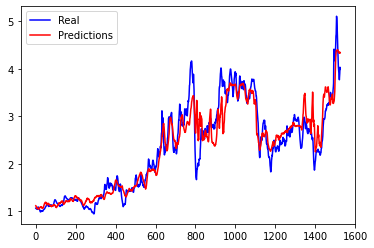

In [6]:
plt.plot(range(len(data)-16), train_y, color='blue', label='Real')
plt.plot(range(len(data)-16), preds, color='red', label='Predictions')
plt.legend()
plt.show()